In [89]:
import pandas as pd
import matplotlib.pyplot as plt

hourly = pd.DataFrame()

hourly = pd.read_csv('../lesson_30/btcusd_1-min_data.csv')
hourly['Timestamp'] = pd.to_datetime(hourly['Timestamp'], unit='s', utc=True)
hourly = hourly.set_index('Timestamp')

hourly = hourly.resample('h').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
})

print(f"Начало: {hourly.index.min()}")
print(f"Конец: {hourly.index.max()}")
print(f"Количество строк: {len(hourly)}")
print(f"\nПервые несколько строк:")
print(hourly.head())
print(f"\nИнформация о типах данных:")
print(hourly.dtypes)


Начало: 2012-01-01 10:00:00+00:00
Конец: 2025-12-07 23:00:00+00:00
Количество строк: 122150

Первые несколько строк:
                           Open  High   Low  Close  Volume
Timestamp                                                 
2012-01-01 10:00:00+00:00  4.58  4.58  4.58   4.58     0.0
2012-01-01 11:00:00+00:00  4.58  4.58  4.58   4.58     0.0
2012-01-01 12:00:00+00:00  4.58  4.58  4.58   4.58     0.0
2012-01-01 13:00:00+00:00  4.58  4.58  4.58   4.58     0.0
2012-01-01 14:00:00+00:00  4.58  4.58  4.58   4.58     0.0

Информация о типах данных:
Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
dtype: object


In [90]:
print(hourly.isna().sum())

Open      18
High      18
Low       18
Close     18
Volume     0
dtype: int64


In [91]:
hourly = hourly.ffill()

Text(0.5, 0, 'Год')

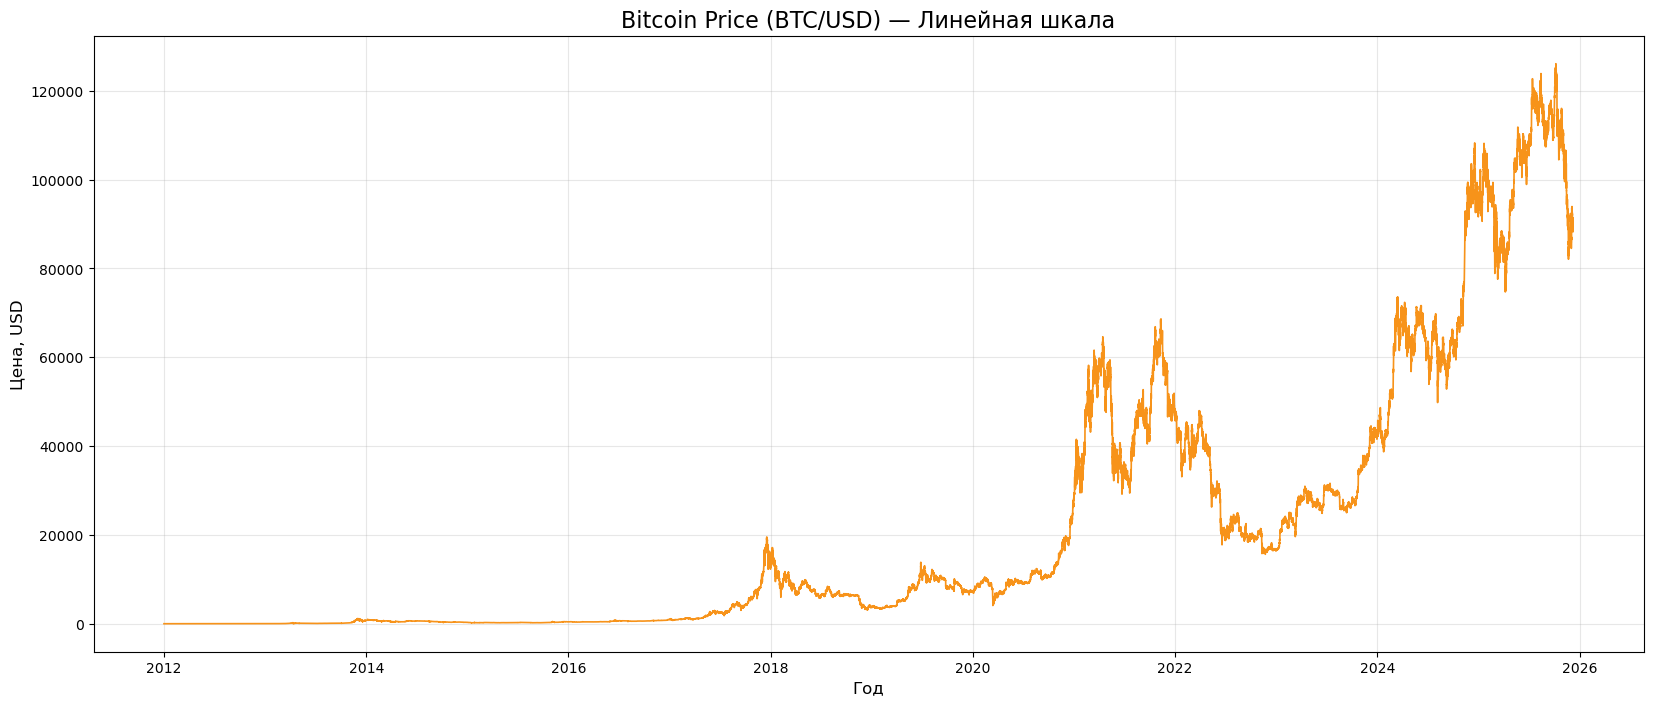

In [92]:
plt.figure(figsize=(20, 8))
plt.plot(hourly.index, hourly['Close'], color='#f7931a', linewidth=1.2)
plt.title(f'Bitcoin Price (BTC/USD) — Линейная шкала', fontsize=16)
plt.ylabel('Цена, USD', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xlabel('Год', fontsize=12)

Prophet основана на аддитивной модели временных рядов (additive model), которая разбивает ряд на независимые компоненты. Основная формула модели:
![](img/img_1.png)


Модель обучается с помощью байесовского вывода (Bayesian inference), что позволяет учитывать priors (априорные распределения) для параметров и генерировать интервалы неопределенности (например, 80% или 95% доверительные интервалы)

Тренд (g(t)):
Prophet моделирует тренд как piecewise linear (кусочно-линейный)
![](img/img_2.png)

Сезонность (s(t)):
![](img/img_3.png)

Праздники и события (h(t)):
![](img/img_4.png)

Ошибка epsilon_{t} содержит информацию, которая не учтена моделью


In [93]:
import numpy as np

print(f"\nСтатистика по Close:")
print(hourly['Close'].describe())

print(f"\nБесконечные значения в Close: {(hourly['Close'] == np.inf).sum()}")
print(f"Отрицательные значения в Close: {(hourly['Close'] <= 0).sum()}")



Статистика по Close:
count    122150.000000
mean      21354.741608
std       30017.507139
min           4.140000
25%         443.665000
50%        7300.040000
75%       30905.000000
max      126111.000000
Name: Close, dtype: float64

Бесконечные значения в Close: 0
Отрицательные значения в Close: 0


In [94]:
from prophet import Prophet
from datetime import timedelta
import matplotlib.pyplot as plt

last_ts = hourly.index[-1]
print(f"Последняя точка в данных: {last_ts} UTC")

test_start = last_ts - timedelta(days=7)
val_start = test_start - timedelta(days=7)

train_df = hourly[:val_start]
val_df = hourly[val_start:test_start]
test_df = hourly[test_start:]

print(f"Train      : {train_df.index[0].date()} -> {train_df.index[-1].date()}    ({len(train_df)} точек)")
print(f"Validation : {val_df.index[0].date()} -> {val_df.index[-1].date()}    ({len(val_df)} точек)")
print(f"Test       : {test_df.index[0].date()} -> {test_df.index[-1].date()}    ({len(test_df)} точек)")

Последняя точка в данных: 2025-12-07 23:00:00+00:00 UTC
Train      : 2012-01-01 -> 2025-11-23    (121814 точек)
Validation : 2025-11-23 -> 2025-11-30    (169 точек)
Test       : 2025-11-30 -> 2025-12-07    (169 точек)


In [95]:
train_ph = train_df[['Close']].reset_index().rename(columns={'Timestamp': 'ds', 'Close': 'y'})
val_ph   = val_df[['Close']].reset_index().rename(columns={'Timestamp': 'ds', 'Close': 'y'})
test_ph  = test_df[['Close']].reset_index().rename(columns={'Timestamp': 'ds', 'Close': 'y'})

train_ph['ds'] = train_ph['ds'].dt.tz_convert(None)
val_ph['ds']   = val_ph['ds'].dt.tz_convert(None)
test_ph['ds']  = test_ph['ds'].dt.tz_convert(None)

In [96]:
model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10.0
)
model.add_country_holidays(country_name='US')

model.fit(train_ph)

14:17:15 - cmdstanpy - INFO - Chain [1] start processing
14:18:15 - cmdstanpy - INFO - Chain [1] done processing


In [97]:
def print_error(df_real, name):
    future_temp = pd.concat([train_ph[['ds']], df_real[['ds']]]).drop_duplicates()
    forecast = model.predict(future_temp)
    merged = df_real.merge(forecast[['ds', 'yhat']], on='ds')
    mae  = abs(merged['y'] - merged['yhat']).mean()
    mape = 100 * abs((merged['y'] - merged['yhat']) / merged['y']).mean()
    print(f"{name:11} → MAE = ${mae:,.0f}   |   MAPE = {mape:.2f}%")

print("\nКачество модели:")
print_error(val_ph,  "Validation")
print_error(test_ph, "Test")


Качество модели:
Validation  → MAE = $30,281   |   MAPE = 33.84%
Test        → MAE = $31,315   |   MAPE = 34.85%


In [98]:
val_ph_plot = val_ph.copy()
test_ph_plot = test_ph.copy()
val_ph_plot['ds'] = pd.to_datetime(val_ph['ds']).dt.tz_localize('UTC')
test_ph_plot['ds'] = pd.to_datetime(test_ph['ds']).dt.tz_localize('UTC')

forecast_val = model.predict(val_ph[['ds']])
forecast_test = model.predict(test_ph[['ds']])

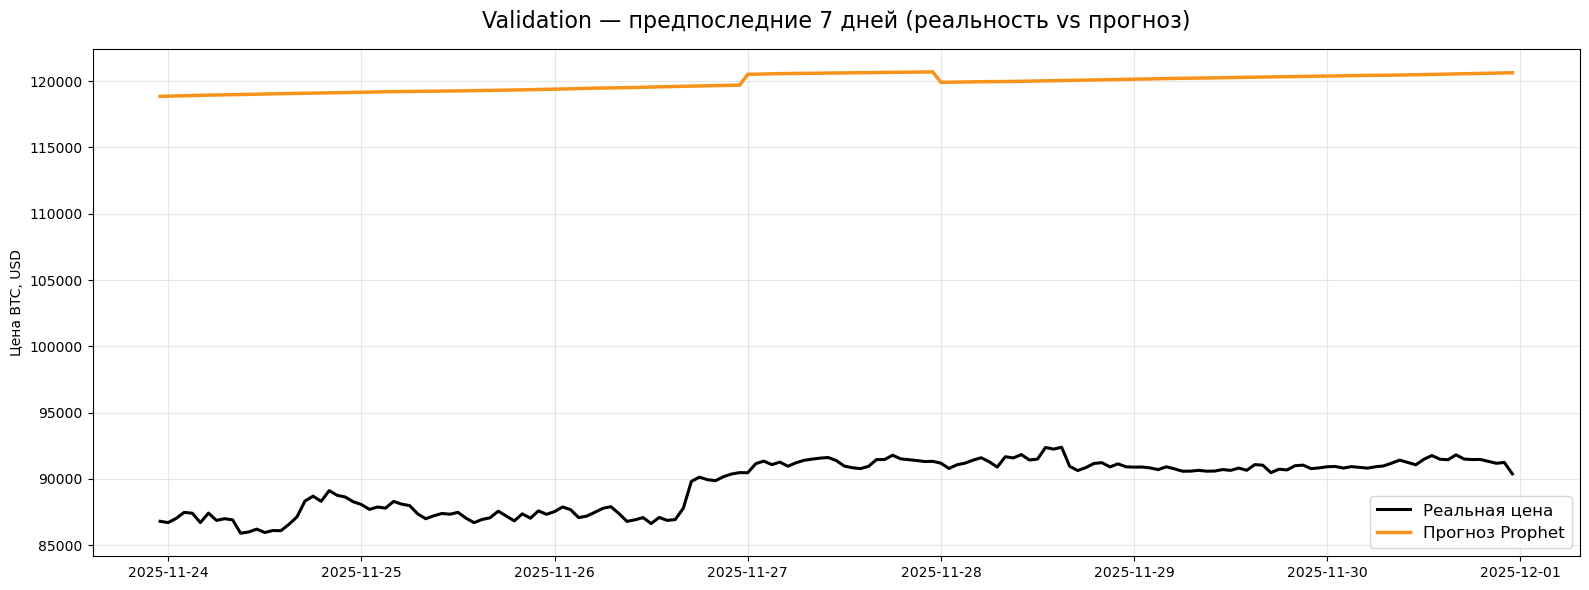

In [99]:
plt.figure(figsize=(16, 6))
plt.plot(val_ph_plot['ds'], val_ph_plot['y'],    color='black',     linewidth=2.2, label='Реальная цена')
plt.plot(val_ph_plot['ds'], forecast_val['yhat'], color='#f7931a', linewidth=2.5, label='Прогноз Prophet')

plt.title('Validation — предпоследние 7 дней (реальность vs прогноз)', fontsize=16, pad=15)
plt.ylabel('Цена BTC, USD')
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()